# Two-layer neural networks in the teacher-student setting

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Teacher Network
def generate_teacher(d, m0):
    w1 = torch.randn(m0, d)
    w1 = w1 / w1.norm(dim=1, keepdim=True)  # Normalize rows
    w2 = torch.sign(torch.randn(m0))
    return w1, w2

def teacher_output(X, w1, w2):
    return torch.sum(w2[:, None] * torch.relu(w1 @ X.T), dim=0)

# Student Network
class StudentNetwork(nn.Module):
    def __init__(self, m, d, tau, symmetrize=False):
        super(StudentNetwork, self).__init__()
        
        # Initialize hidden weights
        hidden_weights = tau * torch.randn(m, d)
        
        if symmetrize:
            if m % 2 != 0:
                raise ValueError("Number of neurons 'm' must be even for symmetrized initialization.")
            
            half_m = m // 2
            
            # First half: random initialization
            hidden_weights[:half_m, :] = tau * torch.randn(half_m, d)
            
            # Second half: copy of the first half
            hidden_weights[half_m:, :] = hidden_weights[:half_m, :].clone()
        
        self.hidden_weights = nn.Parameter(hidden_weights)
        
        # Initialize output weights
        output_weights = tau * torch.randn(m)
        
        if symmetrize:
            if m % 2 != 0:
                raise ValueError("Number of neurons 'm' must be even for symmetrized initialization.")
            
            half_m = m // 2
            
            # First half: absolute values to ensure non-negative
            output_weights[:half_m] = torch.abs(output_weights[:half_m])
            
            # Second half: negative of the first half
            output_weights[half_m:] = -torch.abs(output_weights[:half_m])
        
        self.output_weights = nn.Parameter(output_weights)
    
    def forward(self, X):
        hidden_output = torch.relu(self.hidden_weights @ X.T)  # (m, n)
        return torch.sum(self.output_weights[:, None] * hidden_output, dim=0)  # (n,)

# Training and Evaluation with Early Stopping
def train_student(X_train, Y_train, X_test, Y_test, W_init_tau, stepsize, niter, scaling,
                 symmetrized=False, early_stopping=False, patience=100, delta=1e-4, verbose=False):

    # Initialize the student network
    student = StudentNetwork(m, d, W_init_tau, symmetrized)
    optimizer = optim.SGD(student.parameters(), lr=stepsize / scaling)

    train_losses = []
    test_losses = []
    weight_history = []  # To store weights at each iteration

    # Initialize variables for early stopping
    best_loss = float('inf')
    counter = 0

    # Extract initial weights for reference
    initial_weights = []
    for param in student.parameters():
        initial_weights.append(param.data.cpu().numpy().flatten())
    initial_weights = np.concatenate(initial_weights)
    weight_history.append(initial_weights)

    for epoch in range(niter):
        # Forward pass on training data
        Y_pred_train = scaling * student(X_train)
        train_loss = 0.5 * torch.mean((Y_pred_train - Y_train) ** 2)/(scaling**2)
        train_losses.append(train_loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Record current weights after the optimizer step
        current_weights = []
        for param in student.parameters():
            current_weights.append(param.data.cpu().numpy().flatten())
        current_weights = np.concatenate(current_weights)
        weight_history.append(current_weights)

        # Forward pass on test data
        with torch.no_grad():
            Y_pred_test = scaling * student(X_test)
            test_loss = 0.5 * torch.mean((Y_pred_test - Y_test) ** 2)/(scaling**2)
            test_losses.append(test_loss.item())

        # Early Stopping Check
        if early_stopping:
            if test_loss + delta < best_loss:
                best_loss = test_loss
                counter = 0
                if verbose:
                    print(f"Epoch {epoch}: Test loss improved to {test_loss.item():.6f}. Resetting counter.")
            else:
                counter += 1
                if verbose:
                    print(f"Epoch {epoch}: No improvement in test loss. Counter = {counter}/{patience}")
                if counter >= patience:
                    if verbose:
                        print(f"Early stopping triggered at epoch {epoch}.")
                    break  # Exit the training loop

    return train_losses, test_losses, weight_history




### 1st experiment scale of weight tau compared to test loss at end of training

In [2]:
def experiment_tau_scale_weight():
    
    # Main Experiment Loop
    all_train_losses = np.zeros((niter, len(taus), ntrials))
    all_test_losses = np.zeros((niter, len(taus), ntrials))
    
    pbar = tqdm(total=len(taus) * ntrials)
    
    for trial in range(ntrials):
        # Generate teacher network and datasets
        w1_teacher, w2_teacher = generate_teacher(d, m0)
    
        X_train = torch.randn(n_train, d)
        X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
        Y_train = teacher_output(X_train, w1_teacher, w2_teacher)
    
        X_test = torch.randn(n_test, d)
        X_test = X_test / X_test.norm(dim=1, keepdim=True)
        Y_test = teacher_output(X_test, w1_teacher, w2_teacher)
    
        for i, tau in enumerate(taus):
            stepsize =min(10, 0.1 / tau**2)
    
            train_losses, test_losses,_ = train_student(
                X_train, Y_train, X_test, Y_test, tau, stepsize, niter, scaling, symmetrized
            )
    
            all_train_losses[:, i, trial] = train_losses
            all_test_losses[:, i, trial] = test_losses
    
            pbar.update(1)
    
    pbar.close()
    
    # Compute mean and std of test loss
    mean_test_loss_end = all_test_losses[-1, :, :].mean(axis=1)
    std_test_loss_end = all_test_losses[-1, :, :].std(axis=1)
    mean_test_loss_best = all_test_losses.min(axis=0).mean(axis=1)
    std_test_loss_best = all_test_losses.min(axis=0).std(axis=1)
    
    # Plot Results
    plt.figure(figsize=(6, 6))
    plt.fill_between(taus, mean_test_loss_end + std_test_loss_end, mean_test_loss_end - std_test_loss_end, alpha=0.5, color='gray', label='End of training (± std)')
    plt.fill_between(taus, mean_test_loss_best + std_test_loss_best, mean_test_loss_best - std_test_loss_best, alpha=0.5, color='lightblue', label='Best (± std)')
    plt.semilogx(taus, mean_test_loss_end, 'k-', linewidth=2, label='End of training (mean)')
    plt.semilogx(taus, mean_test_loss_best, 'b--', linewidth=2, label='Best during training (mean)')
    plt.xlabel(r"Initialization ($\tau$)")
    plt.ylabel("Test loss")
    plt.legend()
    plt.title("Test Loss vs Initialization tau")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


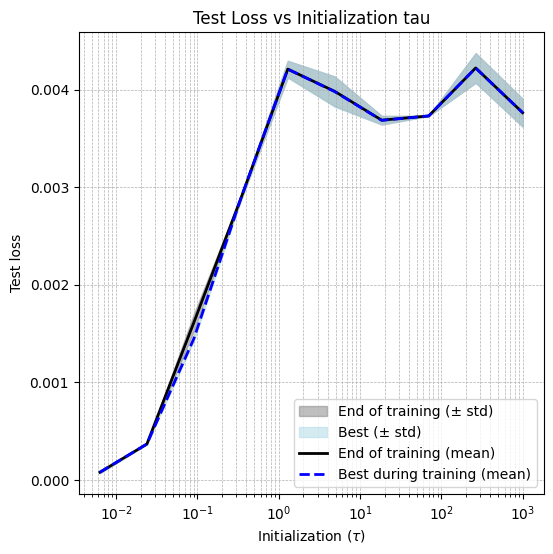

In [8]:
# Parameters
d = 100  # Input dimension
n_train, n_test = 1000, 1000  # Training and test dataset sizes
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 2000#10000  # Number of iterations
taus = np.logspace(-2.2, 3, num=10)  # Initialization taus
ntrials = 2  # Number of trials
scaling = 1.0  # Scaling factor
symmetrized = False
early_stopping=False
patience=200
experiment_tau_scale_weight()

### I) Experiment trajectory of weight in lazy => return the sum of distances in a plot

Two mains obersvations : 
1) when no early stopping is set the lazy change a bit its weight compare to the non lazy
2) When early stopping is set, the non lazy stop WAY before its training => more litlle weight, closer from it's minima

In [10]:
def compute_relative_diff_sum(weight_history):
    initial_weights = weight_history[0]
    weight_history = weight_history[1:]
    s_list = []
    epsilon = 1e-8  # Small value to prevent division by zero

    for current_weights in weight_history:
        # Compute absolute differences
        abs_diff = np.abs(current_weights - initial_weights)
        
        # Compute relative differences, handling division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            rel_diff = np.where(np.abs(initial_weights) > epsilon, abs_diff / np.abs(initial_weights), 0.0)
        
        # Sum over all weights
        s = np.sum(rel_diff)
        s_list.append(s)
    
    return s_list

Stepsize for No Lazy (tau=0.1): 9.999999999999998
Stepsize for Lazy (tau=2): 0.025
Starting No Lazy Training...
No Lazy Training Completed.
Starting Lazy Training...
Lazy Training Completed.


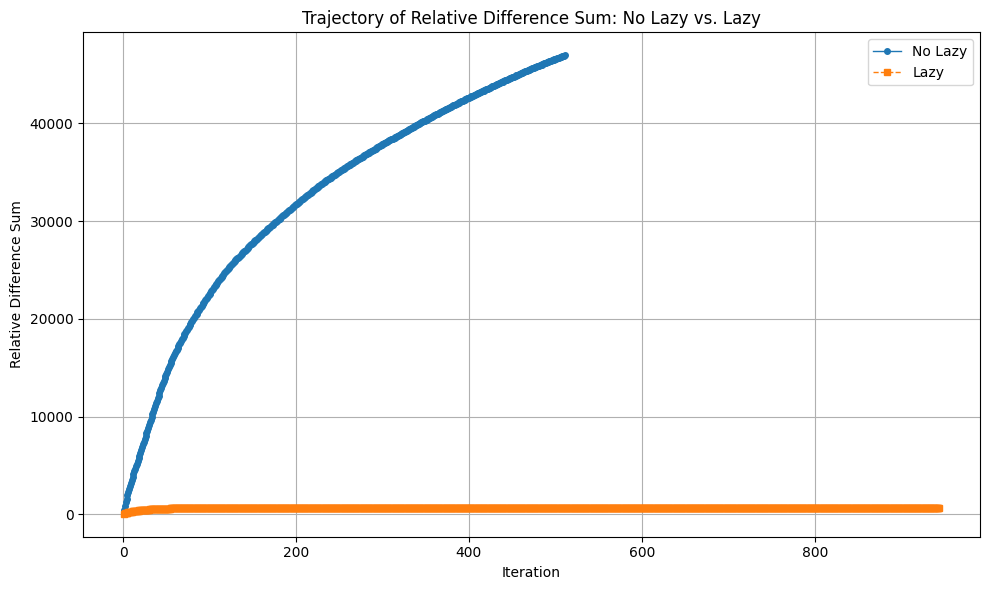

In [12]:

# Experiment: Trajectory of Relative Difference Sum for No Lazy vs. Lazy
def experiment_trajectory_weights():
    # Define local parameters
    d = 100  # Input dimension
    n_train, n_test = 1000, 1000  # Training and test dataset sizes
    m0 = 3  # Number of neurons in the teacher network
    m = 50  # Number of neurons in the student network
    niter = 10000  # Number of iterations
    scaling = 1.0  # Scaling factor
    symmetrized = False
    early_stopping = True
    patience = 200

    # Define tau values
    no_lazy_tau = 0.1
    lazy_tau = 2

    # Compute stepsize for each tau
    stepsize_no_lazy = min(10, 0.1 / (no_lazy_tau ** 2))  # min(10, 0.1 / 0.01) = min(10, 10) = 10
    stepsize_lazy = min(10, 0.1 / (lazy_tau ** 2))        # min(10, 0.1 / 4) = min(10, 0.025) = 0.025

    print(f"Stepsize for No Lazy (tau={no_lazy_tau}): {stepsize_no_lazy}")
    print(f"Stepsize for Lazy (tau={lazy_tau}): {stepsize_lazy}")

    # Generate teacher network and datasets
    w1_teacher, w2_teacher = generate_teacher(d, m0)

    X_train = torch.randn(n_train, d)
    X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
    Y_train = teacher_output(X_train, w1_teacher, w2_teacher)

    X_test = torch.randn(n_test, d)
    X_test = X_test / X_test.norm(dim=1, keepdim=True)
    Y_test = teacher_output(X_test, w1_teacher, w2_teacher)
    
    # No Lazy Training
    print("Starting No Lazy Training...")
    train_losses_no_lazy, test_losses_no_lazy, weights_list_no_lazy = train_student(
        X_train, Y_train, X_test, Y_test, no_lazy_tau, stepsize_no_lazy, niter, scaling, symmetrized,
        early_stopping=early_stopping, patience=patience, verbose=False
    )
    no_lazy_trajectory_weight = compute_relative_diff_sum(weights_list_no_lazy)
    print("No Lazy Training Completed.")

    # Lazy Training
    print("Starting Lazy Training...")
    train_losses_lazy, test_losses_lazy, weights_list_lazy = train_student(
        X_train, Y_train, X_test, Y_test, lazy_tau, stepsize_lazy, niter, scaling, symmetrized,
        early_stopping=early_stopping, patience=patience, verbose=False
    )
    lazy_trajectory_weight = compute_relative_diff_sum(weights_list_lazy)
    print("Lazy Training Completed.")
    
    # Plotting the Trajectory Weights
    plt.figure(figsize=(10, 6))
    
    # Plot No Lazy Trajectory
    iterations_no_lazy = range(1, len(no_lazy_trajectory_weight) + 1)
    plt.plot(iterations_no_lazy, no_lazy_trajectory_weight, label='No Lazy', marker='o', markersize=4, linestyle='-', linewidth=1)
    
    # Plot Lazy Trajectory
    iterations_lazy = range(1, len(lazy_trajectory_weight) + 1)
    plt.plot(iterations_lazy, lazy_trajectory_weight, label='Lazy', marker='s', markersize=4, linestyle='--', linewidth=1)
    
    # Labeling the plot
    plt.xlabel('Iteration')
    plt.ylabel('Relative Difference Sum')
    plt.title('Trajectory of Relative Difference Sum: No Lazy vs. Lazy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

experiment_trajectory_weights()

### II) Experiment 

Scaling Factor Experiment: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


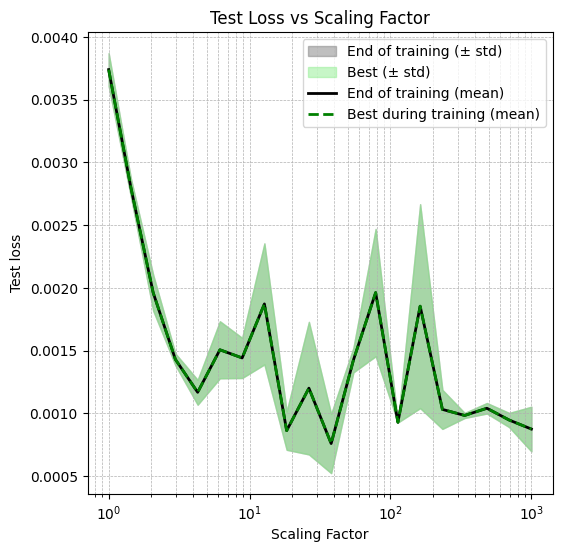

In [14]:
# New Experiment: Varying Scaling Factor
def experiment_scaling_weight():
    
    
    # Initialize arrays to store train and test losses
    all_train_losses = np.zeros((niter, len(scalings), ntrials))
    all_test_losses = np.zeros((niter, len(scalings), ntrials))
    
    pbar = tqdm(total=len(scalings) * ntrials, desc="Scaling Factor Experiment")
    
    for trial in range(ntrials):
        # Generate teacher network and datasets
        w1_teacher, w2_teacher = generate_teacher(d, m0)
    
        X_train = torch.randn(n_train, d)
        X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
        Y_train = teacher_output(X_train, w1_teacher, w2_teacher)
    
        X_test = torch.randn(n_test, d)
        X_test = X_test / X_test.norm(dim=1, keepdim=True)
        Y_test = teacher_output(X_test, w1_teacher, w2_teacher)
    
        for i, scaling in enumerate(scalings):
            # Compute stepsize based on scaling
            stepsize = min(10, 0.1 / scaling**2)
    
            train_losses, test_losses, _ = train_student(
                X_train, Y_train, X_test, Y_test, W_init_tau=tau,  
                stepsize=stepsize, niter=niter, scaling=scaling, symmetrized=symmetrized
            )
    
            all_train_losses[:, i, trial] = train_losses
            all_test_losses[:, i, trial] = test_losses
    
            pbar.update(1)
    
    pbar.close()
    
    # Compute mean and std of test loss
    mean_test_loss_end = all_test_losses[-1, :, :].mean(axis=1)
    std_test_loss_end = all_test_losses[-1, :, :].std(axis=1)
    mean_test_loss_best = all_test_losses.min(axis=0).mean(axis=1)
    std_test_loss_best = all_test_losses.min(axis=0).std(axis=1)
    
    # Plot Results
    plt.figure(figsize=(6, 6))
    plt.fill_between(scalings, mean_test_loss_end + std_test_loss_end, mean_test_loss_end - std_test_loss_end, 
                     alpha=0.5, color='gray', label='End of training (± std)')
    plt.fill_between(scalings, mean_test_loss_best + std_test_loss_best, mean_test_loss_best - std_test_loss_best, 
                     alpha=0.5, color='lightgreen', label='Best (± std)')
    plt.semilogx(scalings, mean_test_loss_end, 'k-', linewidth=2, label='End of training (mean)')
    plt.semilogx(scalings, mean_test_loss_best, 'g--', linewidth=2, label='Best during training (mean)')
    plt.xlabel(r"Scaling Factor")
    plt.ylabel("Test loss")
    plt.legend()
    plt.title("Test Loss vs Scaling Factor")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Define local parameters
d = 100  # Input dimension
n_train, n_test = 1000, 1000  # Training and test dataset sizes
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 2000  # Number of iterations
symmetrized = False
early_stopping = True
patience = 200
tau = 0.1
ntrials = 2

# Define the range of scaling factors
scalings = np.logspace(0,3, num=20)  

experiment_scaling_weight()

### Experiment 3:
the more we increase alpha => the more we get into lazy training
The more we increase tau => the more we get into lazy training
How both of them behave ?

In [15]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def experiment_tau_scaling():
    taus = np.logspace(-2.2, 3, num=10)
    scalings = np.logspace(0, 3, num=10) 
    results = {}

    pbar = tqdm(total=len(taus) * len(scalings) , desc="Tau-Scaling Experiment")

    for tau in taus:
        for scaling in scalings:
            
        
            # Generate teacher network and datasets
            w1_teacher, w2_teacher = generate_teacher(d, m0)

            X_train = torch.randn(n_train, d)
            X_train = X_train / X_train.norm(dim=1, keepdim=True)
            Y_train = teacher_output(X_train, w1_teacher, w2_teacher)

            X_test = torch.randn(n_test, d)
            X_test = X_test / X_test.norm(dim=1, keepdim=True)
            Y_test = teacher_output(X_test, w1_teacher, w2_teacher)

            # Compute stepsize based on tau
            stepsize = min(10, 0.1 / tau**2/scaling**2)

            # Train student
            _, test_losses_trial, _ = train_student(
                X_train, Y_train, X_test, Y_test, W_init_tau=tau,
                stepsize=stepsize, niter=niter, scaling=scaling,
                symmetrized=symmetrized, early_stopping=early_stopping,
                patience=patience, delta=1e-4, verbose=False
            )
            
            
            results[(tau, scaling)] = min(test_losses_trial)
            pbar.update(1)

            

    pbar.close()
    #return the log values
    for key,val in results.items():
        results[key] = np.log(val)
        
    return results




# Run the experiment
# Define local parameters
d = 100  # Input dimension
n_train, n_test = 1000, 1000  # Training and test dataset sizes
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 2000  # Number of iterations
symmetrized = False
early_stopping = True
patience = 200
ntrials = 1
results = experiment_tau_scaling()


Tau-Scaling Experiment: 100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


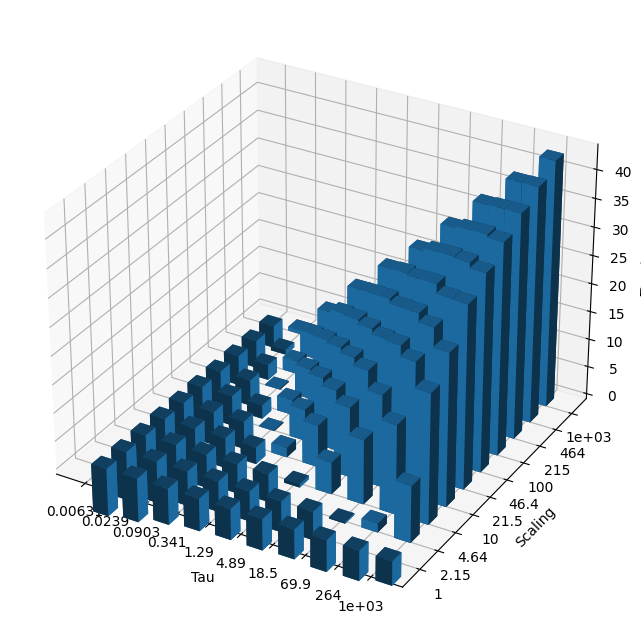

In [6]:



def plot_3d_bar(data_dict):
    # Unpack the dictionary keys and values
    x_vals = np.array([key[0] for key in data_dict.keys()])
    y_vals = np.array([key[1] for key in data_dict.keys()])
    z_vals = np.array(list(data_dict.values()))

    # Create a unique set of x and y for grid formation
    x_unique = np.unique(x_vals)
    y_unique = np.unique(y_vals)

    # Map x and y to indices
    x_indices = np.searchsorted(x_unique, x_vals)
    y_indices = np.searchsorted(y_unique, y_vals)

    # Create a grid for the bar plot
    x_grid, y_grid = np.meshgrid(x_unique, y_unique, indexing='ij')
    z_grid = np.zeros_like(x_grid, dtype=float)

    # Populate the grid with z values
    for i, j, z in zip(x_indices, y_indices, z_vals):
        z_grid[i, j] = z

    # Create the 3D bar plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define bar positions and sizes
    xpos, ypos = np.meshgrid(range(len(x_unique)), range(len(y_unique)), indexing='ij')
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    dx = dy = 0.5  # Width and depth of the bars
    dz = z_grid.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

    # Label axes with actual x and y values
    ax.set_xticks(np.arange(len(x_unique)) + dx / 2)
    ax.set_yticks(np.arange(len(y_unique)) + dy / 2)
    ax.set_xticklabels([f"{val:.3g}" for val in x_unique])
    ax.set_yticklabels([f"{val:.3g}" for val in y_unique])

    ax.set_xlabel("Tau")
    ax.set_ylabel("Scaling")
    ax.set_zlabel("Test loss")

    plt.show()

plot_3d_bar(results)